# AFTD

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
import pandas as pd
from matplotlib import pyplot as plt
import math

In [27]:
def inertia_factory(feat_metric, sample_metric):
    """Calculer inertie par rapport à un point et à un axel"""
    def feat_inner(u, v):
        return (u[None, :] @ feat_metric @ v[:, None]).item()

    def inertia_point(X, p=None):
        """Calcule l'inertie de `X` par rapport au point `p`. Si le point `p`
        n'est pas fourni prendre le centre de gravité.
        """

        if p is None:
            # Calcul du centre de gravité pondéré par `sample_metric`
            p = np.sum(sample_metric @ X, axis=0)

        # Linéarisation au cas où...
        p = p.squeeze()

        # Centrer par rapport à `p`
        Xp = X - p

        # Utiliser la formule du cours avec la trace.
        inertia = sum(np.diag(Xp.T @ sample_metric @ Xp @ feat_metric))

        return inertia

    def inertia_axe(X, v, p=None):
        """Calcule l'inertie de `X` par rapport à la droite pointée par `p` et
        de direction `v`. Si `p` n'est pas fourni, on prend la droite
        qui passe par l'origine (p=0).
        """

        if p is None:
            p = np.zeros(2)

        # Linéarisation au cas où...
        p = p.squeeze()

        def dist_axe_point(v, p, q):
            """Distance d'un point `q` à une droite repérée par un
            vecteur `v` et un point `p`.
            """

            # Normalisation du vecteur `v`
            v = v.ravel()
            v = v / math.sqrt(feat_inner(v, v))

            # Calculer le vecteur perpendiculaire à la droite
            # d'origine q et dont l'extrémité appartient à la droite.
            q_projq = (p - q) - feat_inner(p - q, v) * v

            # Retourner la norme de `q_projq`
            return feat_inner(q_projq, q_projq)

        # Matrice de toutes les distances au carré à la droite
        dists = [dist_axe_point(v, p, q) for q in X]

        # Somme pondérée en fonction de `sample_metric`
        inertia = sum(np.diag(sample_metric) * np.array(dists))

        return inertia

    return feat_inner, inertia_point, inertia_axe


# if __name__ == '__main__':
#     # Exemple d'utilisation de `inertia_factory`.
#     n, p = 100, 2

#     # Matrice M
#     feat_metric = np.eye(p)

#     # Matrice D_p
#     sample_metric = 1 / n * np.eye(n)

#     # Création de `inertia_point` et `inertia_axe` qui calculent
#     # l'inertie par rapport à un point et l'inertie par rapport à un
#     # axe avec les métriques fournies.
#     feat_inner, inertia_point, inertia_axe = inertia_factory(feat_metric, sample_metric)

In [28]:
def plot_Shepard(mds_model, plot=True):
    """Affiche le diagramme de Shepard et retourne un couple contenant les
    dissimilarités originales et les distances apprises par le
    modèle.
    """

    assert isinstance(mds_model, MDS)

    # Inter-distances apprises
    dist = cdist(mds_model.embedding_, mds_model.embedding_)
    idxs = np.tril_indices_from(dist, k=-1)
    dist_mds = dist[idxs]

    # Inter-distances d'origine
    dist = mds_model.dissimilarity_matrix_
    dist_orig = dist[idxs]

    dists = np.column_stack((dist_orig, dist_mds))

    if plot:
        f, ax = plt.subplots()
        range = [dists.min(), dists.max()]
        ax.plot(range, range, 'r--')
        ax.scatter(*dists.T)
        ax.set_xlabel('Dissimilarités')
        ax.set_ylabel('Distances')

    return (*dists.T,)


# Taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

# def plot_clustering(data, labels, markers=None, ax=None, **kwargs):
#     """Affiche dans leur premier plan principal les données `data`,
# colorée par `labels` avec éventuellement des symboles `markers`.
#     """

#     if ax is None:
#         ax = plt.gca()

#     # Reduce to two dimensions
#     if data.shape[1] == 2:
#         data_pca = data.to_numpy()
#     else:
#         pca = PCA(n_components=2)
#         data_pca = pca.fit_transform(data)

#     COLORS = np.array(['blue', 'green', 'red', 'purple', 'gray', 'cyan'])
#     _, labels = np.unique(labels, return_inverse=True)
#     colors = COLORS[labels]

#     if markers is None:
#         ax.scatter(*data_pca.T, c=colors)
#     else:
#         MARKERS = "o^sP*+xD"

#         # Use integers
#         markers_uniq, markers = np.unique(markers, return_inverse=True)

#         for marker in range(len(markers_uniq)):
#             data_pca_marker = data_pca[markers == marker, :]
#             colors_marker = colors[markers == marker]
#             ax.scatter(*data_pca_marker.T, c=colors_marker, marker=MARKERS[marker])

#     if 'centers' in kwargs and 'covars' in kwargs:
#         if data.shape[1] == 2:
#             centers_2D = kwargs['centers']
#             covars_2D = kwargs['covars']
#         else:
#             centers_2D = pca.transform(kwargs["centers"])
#             covars_2D = [
#                 pca.components_ @ c @ pca.components_.T
#                 for c in kwargs['covars']
#             ]

#         p = 0.9
#         sig = norm.ppf(p**(1/2))

#         for i, (covar_2D, center_2D) in enumerate(zip(covars_2D, centers_2D)):
#             v, w = linalg.eigh(covar_2D)
#             print(v)
#             v = 2. * sig * np.sqrt(v)

#             u = w[0] / linalg.norm(w[0])
#             if u[0] == 0:
#                 angle = np.pi / 2
#             else:
#                 angle = np.arctan(u[1] / u[0])

#             color = COLORS[i]
#             angle = 180. * angle / np.pi  # convert to degrees
#             ell = mpl.patches.Ellipse(center_2D, v[0], v[1], 180. + angle, color=color)
#             ell.set_clip_box(ax.bbox)
#             ell.set_alpha(0.5)
#             ax.add_artist(ell)

#     return ax


In [29]:
def add_labels(X , Y, labels):
    for x, y, l in zip(X, Y, labels):
        text = plt.annotate(l, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') 

In [34]:
mut = pd.read_csv("data/mutations2.csv", index_col=0)
mut.shape

(20, 20)

In [35]:
aftd = MDS(n_components=2, dissimilarity='precomputed')
dist = aftd.fit_transform(mut)
dist

array([[ -7.58032178,  13.0586503 ],
       [ -6.84065465,  12.04919301],
       [-11.68368158,   2.80595252],
       [-17.14668142,   0.49500228],
       [-16.09222778,   0.40118966],
       [-13.67746838,   2.32272783],
       [ -8.64290607,   3.19373662],
       [-13.10102294,   6.38898453],
       [ -3.40464075,  -0.99988558],
       [ -3.08529581,   0.45981275],
       [ -3.54096939,  -2.67976051],
       [ -2.28587806,  -1.50459472],
       [ -8.15709767,  -4.65733719],
       [ -2.6433171 ,  25.38250016],
       [-27.18495147, -13.63587989],
       [ -4.54451903, -22.55136863],
       [  5.33583861, -23.96464884],
       [ 44.10515525, -32.70577306],
       [ 42.93400441,  29.39681631],
       [ 57.23663561,   6.74468246]])

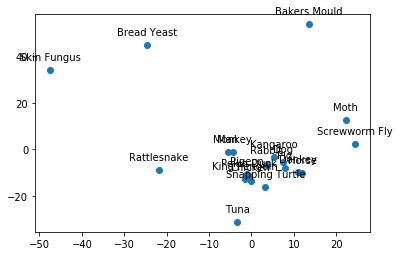

In [6]:
plt.scatter(*dist.T)
add_labels(dist[:, 0], dist[:, 1], mut.index)

In [7]:
dist.shape

(20, 2)

In [8]:
mut

,Man,Monkey,Dog,Horse,Donkey,Pig,Rabbit,Kangaroo,Pekin Duck,Pigeon,Chicken,King Penguin,Snapping Turtle,Rattlesnake,Tuna,Screwworm Fly,Moth,Bakers Mould,Bread Yeast,Skin Fungus
Man,0,1,13,17,16,13,12,12,17,16,18,18,19,20,31,33,36,63,56,66
Monkey,1,0,12,16,15,12,11,13,16,15,17,17,18,21,32,32,35,62,57,65
Dog,13,12,0,10,8,4,6,7,12,12,14,14,13,30,29,24,28,64,61,66
Horse,17,16,10,0,1,5,11,11,16,16,16,17,16,32,27,24,33,64,60,68
Donkey,16,15,8,1,0,4,10,12,15,15,15,16,15,31,26,25,32,64,59,67
Pig,13,12,4,5,4,0,6,7,13,13,13,14,13,30,25,26,31,64,59,67
Rabbit,12,11,6,11,10,6,0,7,10,8,11,11,11,25,26,23,29,62,59,67
Kangaroo,12,13,7,11,12,7,7,0,14,14,15,13,14,30,27,26,31,66,58,68
Pekin Duck,17,16,12,16,15,13,10,14,0,3,3,3,7,24,27,26,30,59,62,66
Pigeon,16,15,12,16,15,13,8,14,3,0,4,4,8,24,27,26,30,59,62,66


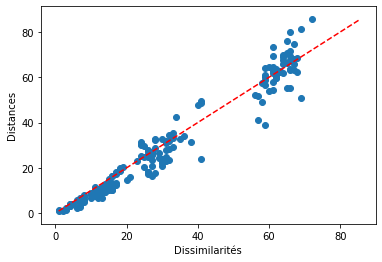

In [36]:
aftd = MDS(n_components=2, dissimilarity='precomputed')
dist = aftd.fit_transform(mut)
plot_Shepard(aftd)
plt.show()

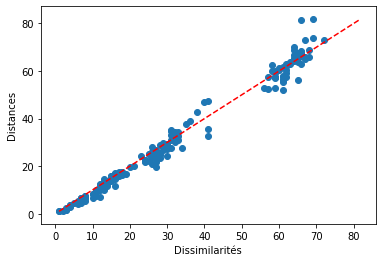

In [21]:
aftd = MDS(n_components=3, dissimilarity='precomputed')
dist = aftd.fit_transform(mut)
plot_Shepard(aftd)
plt.show()

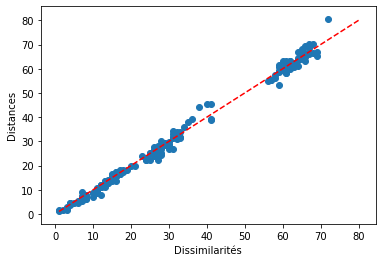

In [23]:
aftd = MDS(n_components=4, dissimilarity='precomputed')
dist = aftd.fit_transform(mut)
plot_Shepard(aftd)
plt.show()

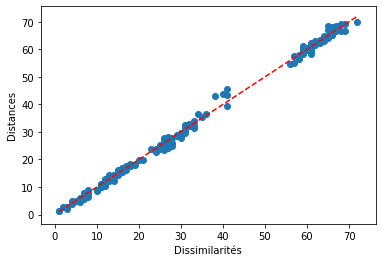

In [24]:
aftd = MDS(n_components=5, dissimilarity='precomputed')
dist = aftd.fit_transform(mut)
plot_Shepard(aftd)
plt.show()

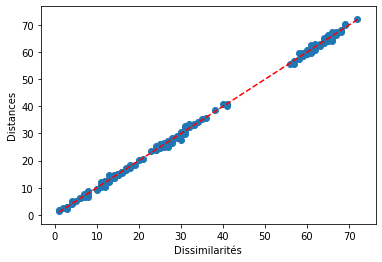

In [51]:
aftd = MDS(n_components=6, dissimilarity='precomputed')
dist = aftd.fit_transform(mut)
plot_Shepard(aftd)
plt.show()

En ré-exécutant ces instructions pour des valeurs croissantes de d, on constate que les points sont de plus en plus proches de la première bissectrice.

In [37]:
aftd.stress_

5402.047532595057

In [38]:
diss, dist = plot_Shepard(aftd, plot=False)

In [39]:
np.sum((diss - dist)**2)

5401.006850661251

# 6

In [52]:
diss, dist = plot_Shepard(aftd, plot=False)
X = np.column_stack((diss, dist))
n, p = X.shape

print(f'n: {n} p: {p}')

stress = np.sum((diss - dist)**2)
print(f"Stress: {stress}")

feat_metric = np.eye(p)
sample_metric = 1 / n * np.eye(n)
feat_inner, inertia_point, inertia_axe = inertia_factory(feat_metric, sample_metric)
inertia = inertia_axe(X, np.ones(2))
print(f"l'inertie sur l'axe bissectrice de Shepard: {inertia}")

ratio = stress/(n*inertia)
print(f"retio between Stress and inertia times number of points: {ratio}")

n: 190 p: 2
Stress: 90.29462563485966
l'inertie sur l'axe bissectrice de Shepard: 0.2376174358812096
retio between Stress and inertia times number of points: 2.0000000000000004


In [ ]:
Les segments des inerties sont inclinés à 45 degrés et les segments du « stress » sont verticaux.
Le rapport des deux vaut donc sin π/4 = sqrt(2)/2. Les segments étant au carré ont retrouve bien le
rapport 1/2.

# 7

In [53]:
diss, dist = plot_Shepard(aftd, plot=False)
X = np.column_stack((diss, dist))
n, p = X.shape

print(f'n: {n} p: {p}')

stress = np.sum((diss - dist)**2)
print(f"Stress: {stress}")

feat_metric = np.array([[2, -1], [-1, 1]])
sample_metric = 1 / n * np.eye(n)
feat_inner, inertia_point, inertia_axe = inertia_factory(feat_metric, sample_metric)
inertia = inertia_axe(X, np.ones(2))
print(f"l'inertie sur l'axe bissectrice de Shepard: {inertia}")

ratio = stress/(n*inertia)
print(f"retio between Stress and inertia times number of points: {ratio}")

n: 190 p: 2
Stress: 90.29462563485966
l'inertie sur l'axe bissectrice de Shepard: 0.4752348717624192
retio between Stress and inertia times number of points: 1.0000000000000002


# Hierarchical Classification

In [59]:
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

In [56]:
# complete: le critère d’agglomération maximum
cls = AgglomerativeClustering(linkage="complete", affinity="euclidean")
cls.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=2)

In [57]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)

<IPython.core.display.Javascript object>


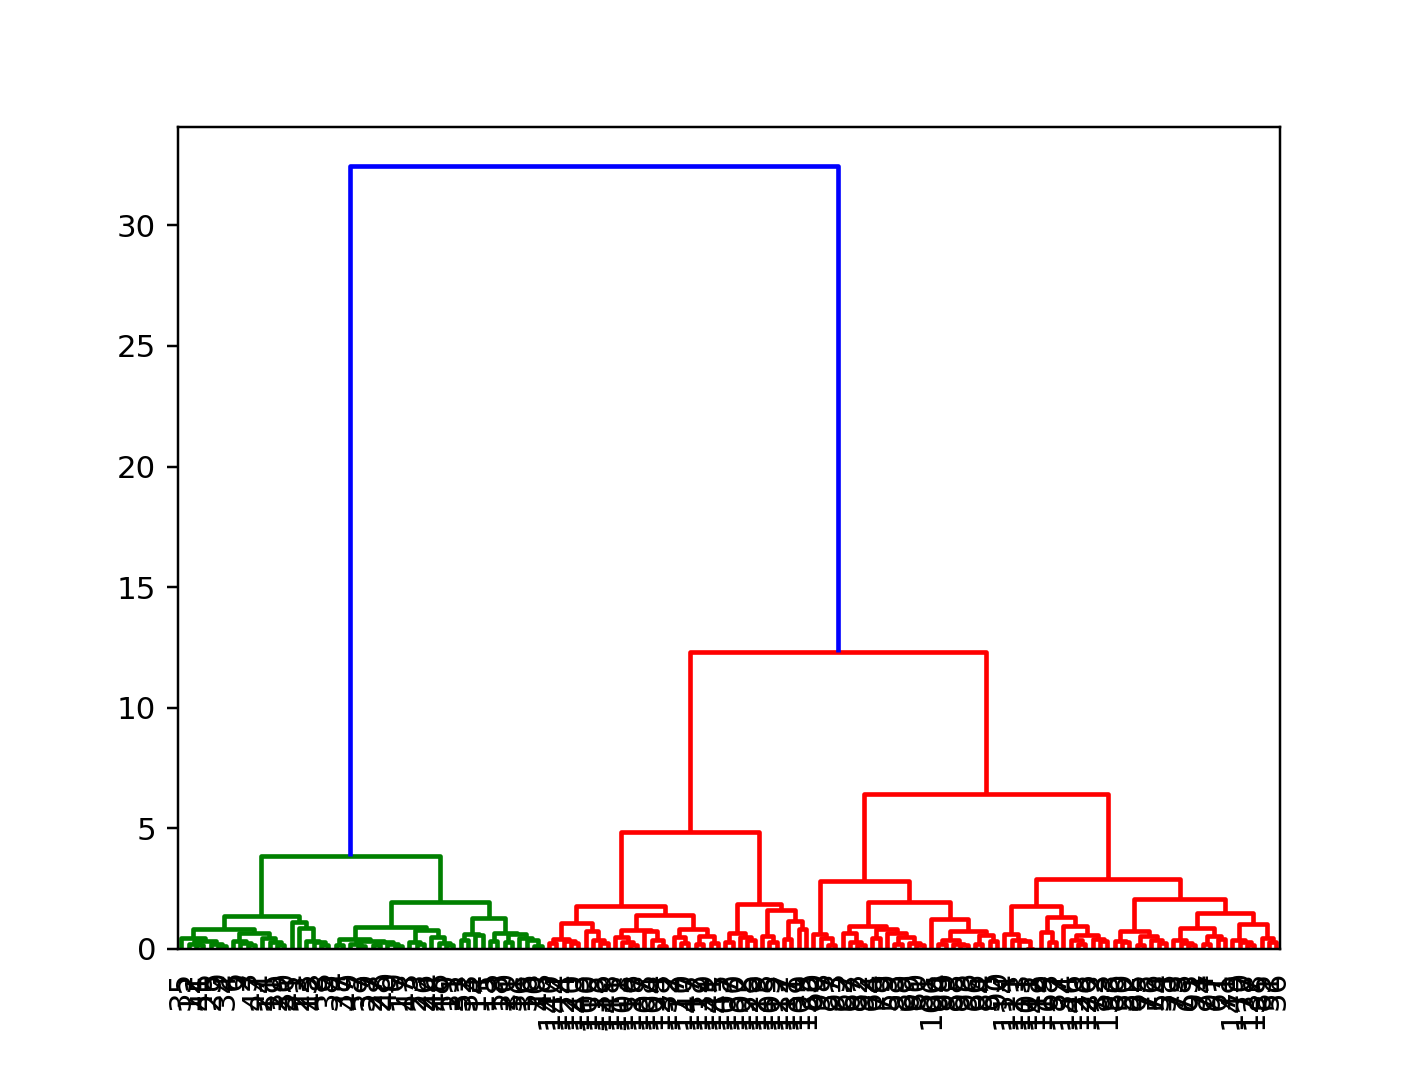

In [68]:
%matplotlib notebook
iris = sns.load_dataset("iris")
cls = AgglomerativeClustering(affinity="euclidean", linkage="ward", distance_threshold=0, n_clusters=None)
cls.fit(iris.drop(columns=["species"]))
plot_dendrogram(cls)
plt.show()

In [63]:
iris.drop(columns=["species"])

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


<IPython.core.display.Javascript object>


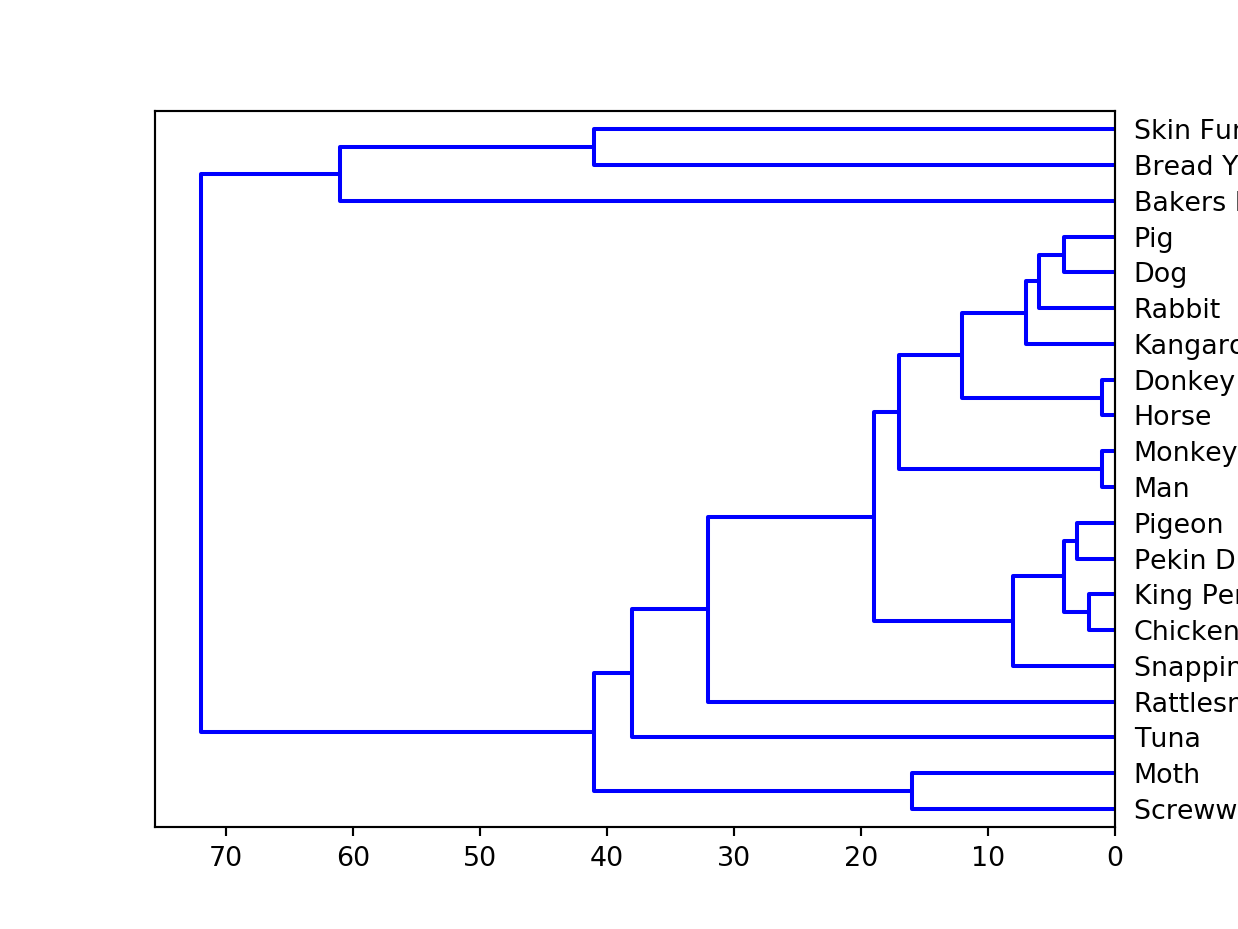

In [72]:
%matplotlib notebook
mut = pd.read_csv("data/mutations2.csv", index_col=0)
model = AgglomerativeClustering(
affinity="precomputed", linkage="complete", distance_threshold=0, n_clusters=None
).fit(mut)
plot_dendrogram(model, color_threshold=1, labels=mut.index, orientation="left")
plt.show()

<IPython.core.display.Javascript object>


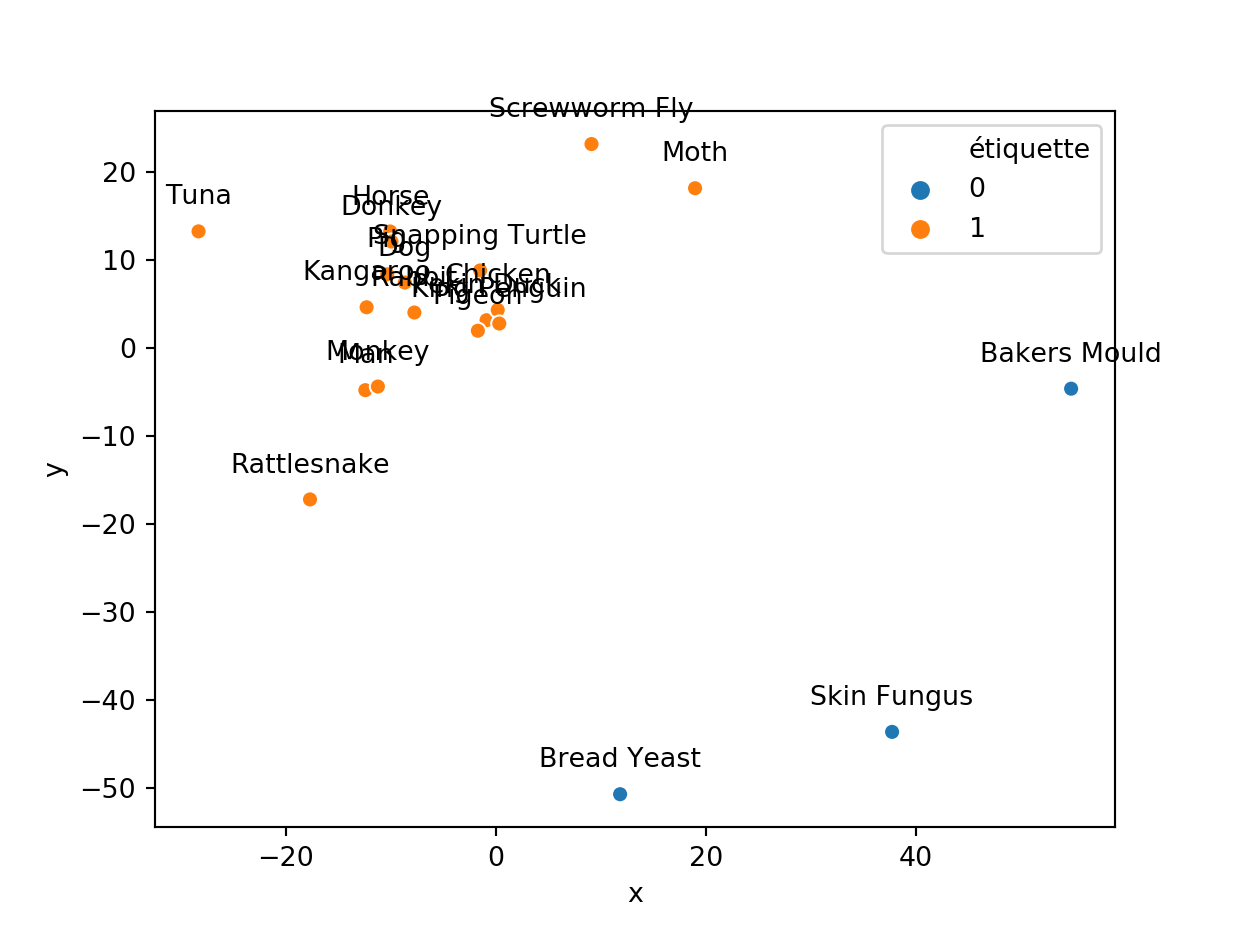

In [73]:
%matplotlib notebook
model = AgglomerativeClustering(
    affinity="precomputed", linkage="complete", n_clusters=2
).fit(mut)
labels = model.labels_
aftd = MDS(n_components=2, dissimilarity="precomputed")
dist = aftd.fit_transform(mut)
df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1], "étiquette": labels})
sns.scatterplot("x", "y", hue="étiquette", data=df)
add_labels(dist[:, 0], dist[:, 1], mut.index)
plt.show()

# Inertie intra-classe et critère de Ward

In [80]:
def inertia(cluster, n):
    nk = cluster.shape[0]
    if nk == 1:
        return 0
    V = np.cov(cluster, rowvar=False, bias=True)
    return nk * np.trace(V) / n

iris = sns.load_dataset("iris")
iris0 = iris.drop(columns="species")
n = iris0.shape[0]

assert math.isclose(inertia(iris0, n), 4.542470666666669)
assert math.isclose(
inertia(iris0.loc[iris.species == "setosa"], n), 0.10100666666666669
)
assert math.isclose(
inertia(iris0.loc[iris.species == "versicolor"], n), 0.20410933333333345
)
assert math.isclose(
inertia(iris0.loc[iris.species == "virginica"], n), 0.29019999999999996
)